In [1]:
import pandas as pd

# 从文件中读取数据并进行解析
df = pd.read_csv('household_power_consumption.txt', sep=';',
                 parse_dates={'datetime':[0,1]},
                 dayfirst=T 
rue,
                 low_memory=False, 
                 na_values=['nan','?'],
                 index_col=['datetime'])


In [2]:
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [3]:
def check_positive_values(df):
    """
    检查 DataFrame 中是否全是正值。
    
    参数：
    df (pandas.DataFrame)：要检查的 DataFrame。
    
    返回：
    bool：如果 DataFrame 中全是正值，则为 True；否则为 False。
    """
    is_all_positive = (df >= 0).all().all()
    if is_all_positive:
        print("DataFrame 中全是正值")
    else:
        print("DataFrame 中包含非正值")




In [5]:
droping_list_all=[]
for j in range(0, 7):
    if not df.iloc[:, j].notnull().all():
        droping_list_all.append(j)
droping_list_all

[0, 1, 2, 3, 4, 5, 6]

In [6]:
df = df.fillna(df.mean()) 

In [7]:
#检测缺失值
df.isnull().sum()
# df.dtypes

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [8]:
check_positive_values(df)

DataFrame 中全是正值


In [9]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    dff = pd.DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(dff.shift(-i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(dff.shift(-i))
        if i==0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1)) for j in range(n_vars)]
        
        agg = pd.concat(cols, axis=1)
        agg.columns = names
        if dropnan:
            agg.dropna(inplace=True)
        return agg

In [10]:
df_resample = df.resample('h').mean()
df_resample.shape

(34589, 7)

In [11]:
from  sklearn.preprocessing import MinMaxScaler

values = df_resample.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, 1, 1)
reframed.drop(reframed.columns[[8,9,10,11,12,13]], axis=1, inplace=True)
reframed.head()  
                    

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var1(t)
0,0.545045,0.103358,0.335501,0.541487,0.0,0.144652,0.782676,0.636816
1,0.509006,0.110073,0.283802,0.502152,0.0,0.030869,0.774169,0.545045
2,0.488550,0.096987,0.315987,0.481110,0.0,0.000000,0.778809,0.509006
3,0.455597,0.099010,0.434417,0.449904,0.0,0.008973,0.798917,0.488550
4,0.322555,0.072536,0.495847,0.323529,0.0,0.002872,0.205723,0.455597


In [12]:
check_positive_values(reframed)

DataFrame 中全是正值


In [13]:
values = reframed.values
n_train_time = 365*24
train = values[:n_train_time, :]
test = values[n_train_time:, :]
train_x, train_y = train[:, :-1], train[:, -1]
test_x, test_y = test[:, :-1], test[:, -1]
train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))
test_x.shape


(25828, 1, 7)

In [20]:
(test_x >= 0).all()

True

In [21]:
from sklearn.metrics import mean_squared_error
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.python.keras.layers import LSTM, Dropout, Dense
from tensorflow.python.keras import Sequential

model = Sequential()
model.add(LSTM(100, input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(Dropout(0.2))
#    model.add(LSTM(70))
#    model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')


Epoch 1/20
126/126 - 1s - loss: 0.0203 - val_loss: 0.0119
Epoch 2/20
126/126 - 0s - loss: 0.0124 - val_loss: 0.0109
Epoch 3/20
126/126 - 0s - loss: 0.0118 - val_loss: 0.0102
Epoch 4/20
126/126 - 0s - loss: 0.0114 - val_loss: 0.0100
Epoch 5/20
126/126 - 0s - loss: 0.0111 - val_loss: 0.0097
Epoch 6/20
126/126 - 0s - loss: 0.0111 - val_loss: 0.0096
Epoch 7/20
126/126 - 0s - loss: 0.0110 - val_loss: 0.0096
Epoch 8/20
126/126 - 0s - loss: 0.0110 - val_loss: 0.0095
Epoch 9/20
126/126 - 0s - loss: 0.0109 - val_loss: 0.0095
Epoch 10/20
126/126 - 0s - loss: 0.0109 - val_loss: 0.0096
Epoch 11/20
126/126 - 0s - loss: 0.0108 - val_loss: 0.0095
Epoch 12/20
126/126 - 0s - loss: 0.0108 - val_loss: 0.0096
Epoch 13/20
126/126 - 0s - loss: 0.0108 - val_loss: 0.0096
Epoch 14/20
126/126 - 0s - loss: 0.0107 - val_loss: 0.0096
Epoch 15/20
126/126 - 0s - loss: 0.0108 - val_loss: 0.0098
Epoch 16/20
126/126 - 0s - loss: 0.0108 - val_loss: 0.0097
Epoch 17/20
126/126 - 1s - loss: 0.0107 - val_loss: 0.0097
Epoch 

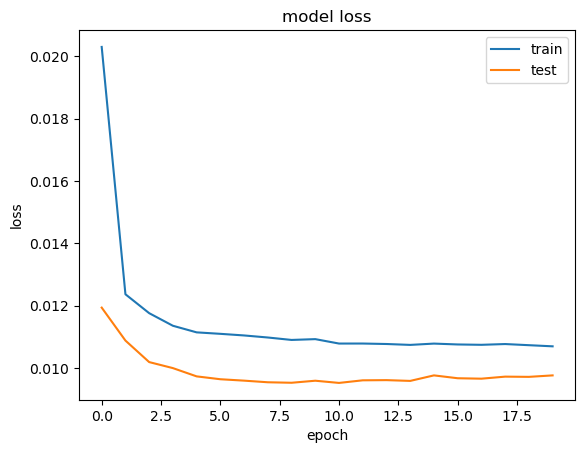

In [22]:

# fit network
history = model.fit(train_x, train_y, epochs=20, batch_size=70, validation_data=(test_x, test_y), verbose=2, shuffle=False)

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [29]:
# make a prediction
yhat = model.predict(test_x.reshape(test_x.shape[0],1,7))
# test_x = test_x.reshape((test_x.shape[0], 7))
# invert scaling for forecast
def invert(yhat, test_x):
    inv_yhat = np.concatenate((yhat, test_x[:, -6:]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,0]
    return inv_yhat
inv_yhat = invert(yhat, test_x)
# invert scaling for actual
# test_y = test_y.reshape((len(test_y), 1))
# inv_y = np.concatenate((test_y, test_x[:, -6:]), axis=1)
# inv_y = scaler.inverse_transform(inv_y)
# inv_y = inv_y[:,0]
inv_y= invert(test_y, test_x)
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.636


In [56]:
type(inv_yhat)

numpy.ndarray

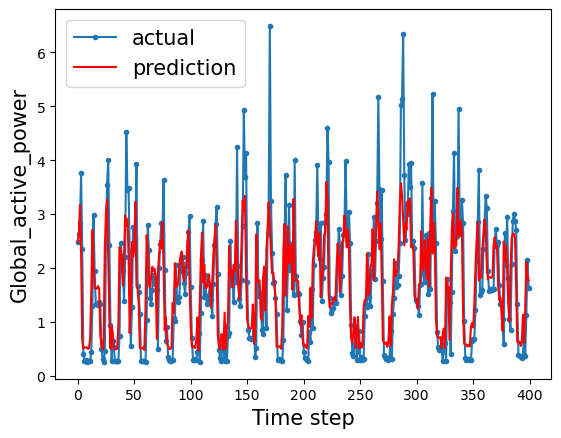

In [11]:
aa=[x for x in range(400)]
plt.plot(aa, inv_y[:400], marker='.', label="actual")
plt.plot(aa, inv_yhat[:400], 'r', label="prediction")
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()

In [33]:
def run_lime_explainer(test_x, index):


    sequence_length = 1
    num_features = 7
    # 选择一个数据点进行解释
    data_point_index = index # 选择第一个数据点
    data_row = test_x[data_point_index].reshape(1, sequence_length, num_features)
    # data_row.shape,test_x.shape
    
    # 生成邻域样本
    num_samples = 1000  # 生成1000个邻域样本
    neighboring_samples = np.empty((num_samples, sequence_length, num_features))
    
    for i in range(num_samples):
        perturbation = np.random.normal(0, 0.1, (sequence_length, num_features))
        neighboring_sample = data_row + perturbation
        neighboring_samples[i] = neighboring_sample
    
    # 定义预测函数，该函数接受时间序列数据并返回模型的预测结果
    def predict_function(data):
        predictions = model.predict(data)
        return predictions
    # 计算邻域样本的预测
    neighbor_predictions = predict_function(neighboring_samples)
    # neighbor_predictions = invert(neighbor_predictions, neighboring_samples)
    
    # 3. 训练解释模型（默认线性模型）
    def train_lime_explainer(neighboring_samples, predictions):
        # 在这里，您可以选择任何解释模型，例如线性回归
        explainer_model = Sequential()
        # explainer_model.add(Dense(1, input_dim=data_row.shape[1]))
        explainer_model.add(Dense(1, input_dim=neighboring_samples.shape[2])) 
        explainer_model.compile(optimizer='adam', loss='mean_squared_error')
        explainer_model.fit(neighboring_samples, predictions, epochs=10, batch_size=32)
        return explainer_model
    
    explainer_model = train_lime_explainer(neighboring_samples, neighbor_predictions)
    
    # 4. 得到每个特征的权重
    def get_feature_weights(explainer_model):
        feature_weights = explainer_model.get_weights()[0]  # 获取模型的权重
        return feature_weights
    
    
    feature_weights = get_feature_weights(explainer_model)
    
    return feature_weights,explainer_model

In [34]:
feature_weights,explainer_model = run_lime_explainer(test_x.reshape(test_x.shape[0],1,7),0)

Epoch 1/10
32/32 [==============================] - 0s 485us/step - loss: 0.0715
Epoch 2/10
32/32 [==============================] - 0s 977us/step - loss: 0.0423
Epoch 3/10
32/32 [==============================] - 0s 488us/step - loss: 0.0300
Epoch 4/10
32/32 [==============================] - 0s 488us/step - loss: 0.0259
Epoch 5/10
32/32 [==============================] - 0s 488us/step - loss: 0.0245
Epoch 6/10
32/32 [==============================] - 0s 488us/step - loss: 0.0236
Epoch 7/10
32/32 [==============================] - 0s 488us/step - loss: 0.0229
Epoch 8/10
32/32 [==============================] - 0s 488us/step - loss: 0.0222
Epoch 9/10
32/32 [==============================] - 0s 488us/step - loss: 0.0215
Epoch 10/10
32/32 [==============================] - 0s 488us/step - loss: 0.0209


In [36]:
print(feature_weights)

[[-0.3460889 ]
 [ 0.07396665]
 [ 0.45089242]
 [-0.55200076]
 [-0.38042107]
 [-0.35044327]
 [ 0.73530686]]


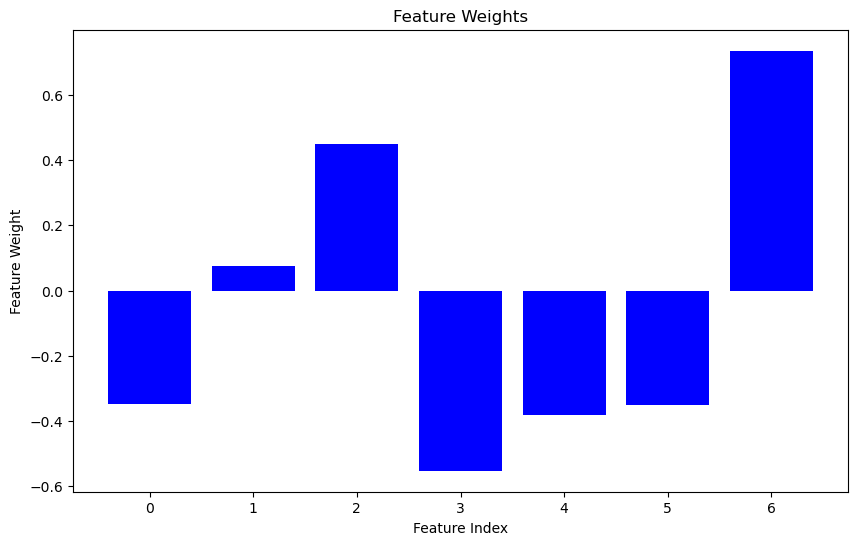

In [37]:
def visualize_feature_weights(feature_weights):
    # 提取 NumPy 数组
    # feature_weights = feature_weights[0]
    # 将 feature_weights 转换为一维 NumPy 数组
    feature_weights = feature_weights.flatten()
    
    num_features = len(feature_weights)
    feature_indices = range(num_features)
    
    plt.figure(figsize=(10, 6))
    plt.bar(feature_indices, feature_weights, color='blue')
    plt.xlabel('Feature Index')
    plt.ylabel('Feature Weight')
    plt.title('Feature Weights')
    plt.show()

# 使用可视化函数
visualize_feature_weights(feature_weights)

In [39]:
#随机从测试集里选取多个样本点

# 定义要抽取的数据点数量
num_samples_to_extract = 100

# 从测试集中随机抽取100个数据点的索引
random_sample_indices = np.random.choice(len(test_x), num_samples_to_extract, replace=False)


# 根据随机抽取的索引获取相应的数据点
test_data = test_x[random_sample_indices]


In [57]:
# 使用原始LSTM模型对整个测试数据集进行预测
original_predictions = model.predict(test_data.reshape(test_data.shape[0],1,7))
print(original_predictions)
(original_predictions>=0).all(
)

[[0.3975898 ]
 [0.187196  ]
 [0.13276702]
 [0.0683919 ]
 [0.16682482]
 [0.0823281 ]
 [0.16746102]
 [0.07699928]
 [0.10280578]
 [0.44009268]
 [0.0787398 ]
 [0.1713869 ]
 [0.09592987]
 [0.3728218 ]
 [0.07935724]
 [0.20984928]
 [0.09343561]
 [0.20458843]
 [0.0817553 ]
 [0.09743239]
 [0.06591411]
 [0.1341808 ]
 [0.08816627]
 [0.12501553]
 [0.25889945]
 [0.1943811 ]
 [0.2789629 ]
 [0.08100603]
 [0.32121152]
 [0.253062  ]
 [0.23283522]
 [0.06897954]
 [0.32712752]
 [0.38106334]
 [0.18856718]
 [0.18668854]
 [0.18856718]
 [0.26187235]
 [0.10039704]
 [0.18984862]
 [0.24276629]
 [0.06069486]
 [0.29877502]
 [0.09086274]
 [0.19557427]
 [0.09479071]
 [0.20909713]
 [0.25403208]
 [0.27373898]
 [0.18379156]
 [0.09407599]
 [0.137745  ]
 [0.12141375]
 [0.38292193]
 [0.24782376]
 [0.1891842 ]
 [0.31379902]
 [0.09775005]
 [0.29616076]
 [0.10873595]
 [0.26208365]
 [0.35621023]
 [0.35103834]
 [0.22720827]
 [0.27232742]
 [0.23463501]
 [0.3441375 ]
 [0.40534687]
 [0.07347593]
 [0.25641054]
 [0.0702378 ]
 [0.07

True

In [72]:
# 使用LIME解释器对相同的测试数据集进行解释
lime_predictions = []

for i in random_sample_indices:
    _, lime_model = run_lime_explainer(test_x,i)
    lime_prediction = lime_model.predict(test_x[i].reshape(1,1,7))
    lime_predictions.append(lime_prediction[0])

Epoch 1/10
32/32 [==============================] - 0s 488us/step - loss: 0.5922
Epoch 2/10
32/32 [==============================] - 0s 488us/step - loss: 0.4391
Epoch 3/10
32/32 [==============================] - 0s 508us/step - loss: 0.3180
Epoch 4/10
32/32 [==============================] - 0s 469us/step - loss: 0.2255
Epoch 5/10
32/32 [==============================] - 0s 489us/step - loss: 0.1560
Epoch 6/10
32/32 [==============================] - 0s 488us/step - loss: 0.1055
Epoch 7/10
32/32 [==============================] - 0s 488us/step - loss: 0.0701
Epoch 8/10
32/32 [==============================] - 0s 488us/step - loss: 0.0460
Epoch 9/10
32/32 [==============================] - 0s 488us/step - loss: 0.0303
Epoch 10/10
32/32 [==============================] - 0s 715us/step - loss: 0.0203
Epoch 1/10
32/32 [==============================] - 0s 488us/step - loss: 0.0952
Epoch 2/10
32/32 [==============================] - 0s 488us/step - loss: 0.0584
Epoch 3/10
32/32 [=========

In [74]:
lime_predictions= np.array([fw[0] for fw in lime_predictions])
print(lime_predictions.shape)

(100, 1)


In [75]:

# print(lime_predictions,'\n---------\n',original_predictions)

lime_predictions = invert(lime_predictions,test_data)
# print(lime_predictions,'\n---------\n',original_predictions)

In [76]:
original_predictions = invert(original_predictions,test_data)

In [77]:
rmse = np.sqrt(mean_squared_error(lime_predictions, original_predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.572


In [83]:
(original_predictions>=0).all()

True

In [91]:
from sklearn.tree import DecisionTreeRegressor


def run_lime_explainer(test_x, index):


    sequence_length = 1
    num_features = 7
    # 选择一个数据点进行解释
    data_point_index = index # 选择第一个数据点
    data_row = test_x[data_point_index].reshape(1, sequence_length, num_features)
    # data_row.shape,test_x.shape
    
    # 生成邻域样本
    num_samples = 1000  # 生成1000个邻域样本
    neighboring_samples = np.empty((num_samples, sequence_length, num_features))
    
    for i in range(num_samples):
        perturbation = np.random.normal(0, 0.1, (sequence_length, num_features))
        neighboring_sample = data_row + perturbation
        neighboring_samples[i] = neighboring_sample
    
    # 定义预测函数，该函数接受时间序列数据并返回模型的预测结果
    def predict_function(data):
        predictions = model.predict(data)
        return predictions
    # 计算邻域样本的预测
    neighbor_predictions = predict_function(neighboring_samples)
    # neighbor_predictions = invert(neighbor_predictions, neighboring_samples)
    
    def train_lime_explainer(neighboring_samples, predictions):
    # 创建树回归模型，您可以根据需要调整模型的参数
        explainer_model = DecisionTreeRegressor(max_depth=5)  # 例如，这里选择了决策树回归器，您可以根据需要调整参数

    # 训练树回归模型
        explainer_model.fit(neighboring_samples.reshape(-1, num_features), predictions)  # 注意要将数据展平

        return explainer_model
    
    explainer_model = train_lime_explainer(neighboring_samples, neighbor_predictions)
    
    # 4. 得到每个特征的权重
    def get_feature_weights(explainer_model):
        # feature_weights = explainer_model.get_weights()[0]  # 获取模型的权重
        feature_weights = explainer_model.feature_importances_  
        return feature_weights
    
    
    feature_weights = get_feature_weights(explainer_model)
    
    return feature_weights,explainer_model

In [92]:
feature_weights,explainer_model = run_lime_explainer(test_x.reshape(test_x.shape[0],1,7),0)


In [88]:
print(feature_weights)

[0.55718128 0.         0.00118701 0.44012416 0.00150756 0.
 0.        ]


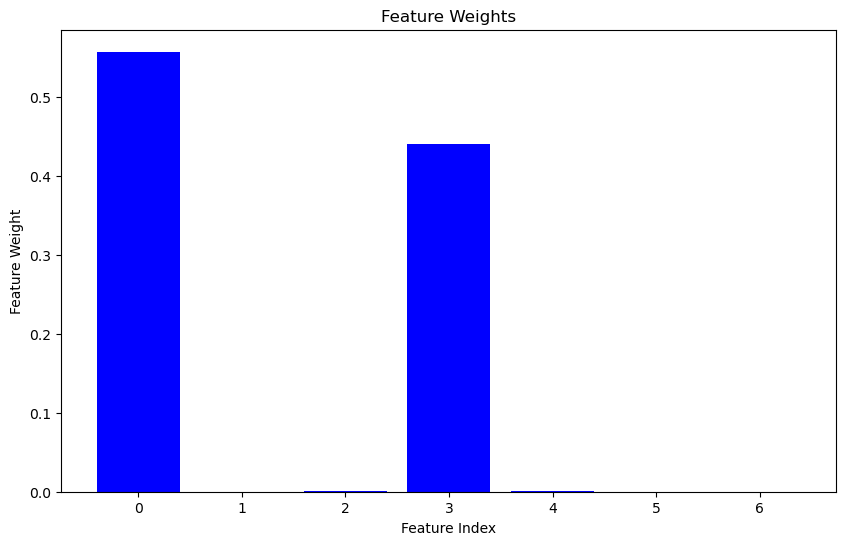

In [87]:
def visualize_feature_weights(feature_weights):
    # 提取 NumPy 数组
    # feature_weights = feature_weights[0]
    # 将 feature_weights 转换为一维 NumPy 数组
    feature_weights = feature_weights.flatten()
    
    num_features = len(feature_weights)
    feature_indices = range(num_features)
    
    plt.figure(figsize=(10, 6))
    plt.bar(feature_indices, feature_weights, color='blue')
    plt.xlabel('Feature Index')
    plt.ylabel('Feature Weight')
    plt.title('Feature Weights')
    plt.show()

# 使用可视化函数
visualize_feature_weights(feature_weights)

In [93]:
#随机从测试集里选取多个样本点

# 定义要抽取的数据点数量
num_samples_to_extract = 100

# 从测试集中随机抽取100个数据点的索引
random_sample_indices = np.random.choice(len(test_x), num_samples_to_extract, replace=False)


# 根据随机抽取的索引获取相应的数据点
test_data = test_x[random_sample_indices]

In [94]:
# 使用原始LSTM模型对整个测试数据集进行预测
original_predictions = model.predict(test_data.reshape(test_data.shape[0],1,7))
print(original_predictions)
(original_predictions>=0).all(
)

[[0.08879761]
 [0.07678632]
 [0.15384787]
 [0.07453295]
 [0.12785535]
 [0.43026912]
 [0.08085576]
 [0.09401251]
 [0.31674343]
 [0.09399846]
 [0.08021662]
 [0.2784736 ]
 [0.15972288]
 [0.3485669 ]
 [0.19322105]
 [0.07733445]
 [0.08598883]
 [0.16356961]
 [0.18837644]
 [0.22441684]
 [0.18856718]
 [0.09728794]
 [0.25187555]
 [0.1705399 ]
 [0.24098833]
 [0.29569018]
 [0.08621307]
 [0.06327373]
 [0.30137545]
 [0.38719678]
 [0.2565897 ]
 [0.5034297 ]
 [0.41428494]
 [0.18269487]
 [0.08133263]
 [0.14758839]
 [0.07581396]
 [0.40226728]
 [0.08139705]
 [0.21307744]
 [0.07602292]
 [0.36323208]
 [0.09328336]
 [0.06131675]
 [0.1020257 ]
 [0.06508268]
 [0.14936765]
 [0.062612  ]
 [0.08270742]
 [0.24745928]
 [0.13109225]
 [0.14870581]
 [0.27708495]
 [0.12839125]
 [0.10553724]
 [0.08535443]
 [0.06971954]
 [0.06400953]
 [0.16199505]
 [0.294679  ]
 [0.17593445]
 [0.06062   ]
 [0.4111622 ]
 [0.18083788]
 [0.13276702]
 [0.3025884 ]
 [0.24179365]
 [0.06769697]
 [0.42503607]
 [0.0735817 ]
 [0.24911752]
 [0.07

True

In [98]:
# 使用LIME解释器对相同的测试数据集进行解释
lime_predictions = []

for i in random_sample_indices:
    _, lime_model = run_lime_explainer(test_x,i)
    lime_prediction = lime_model.predict(test_x[i].reshape(-1,7))
    lime_predictions.append(lime_prediction[0])

In [102]:
lime_predictions = np.array(lime_predictions)

In [106]:
lime_predictions = invert(lime_predictions.reshape(-1,1),test_data)

In [107]:
original_predictions = invert(original_predictions,test_data)

In [108]:
rmse = np.sqrt(mean_squared_error(lime_predictions, original_predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.100


In [109]:
(lime_predictions>=0).all()

True

In [111]:
# 运行LIME多次并记录特征权重
num_runs = 10  # 指定运行的次数
feature_weights_list = []

for _ in range(num_runs):
    # 运行LIME并获取特征权重
    feature_weights, lime_model = run_lime_explainer(test_x,0)
    feature_weights_list.append(feature_weights)

# 计算特征权重向量的方差
variance_per_feature = np.var(feature_weights_list, axis=0)

# 打印每个特征的方差
for feature_idx, variance in enumerate(variance_per_feature):
    print(f"Feature {feature_idx}: Variance = {variance}")

Feature 0: Variance = 0.0009681396480488713
Feature 1: Variance = 0.0
Feature 2: Variance = 0.0
Feature 3: Variance = 0.0009739059285744011
Feature 4: Variance = 2.2623589626144755e-07
Feature 5: Variance = 0.0
Feature 6: Variance = 4.674856905438813e-07


In [262]:
#随机从测试集里选取多个样本点

# 定义要抽取的数据点数量
num_samples_to_extract = 100

# 从测试集中随机抽取100个数据点的索引
random_sample_indices = np.random.choice(len(test_x), num_samples_to_extract, replace=False)
print(random_sample_indices)

# 根据随机抽取的索引获取相应的数据点
test_data = test_x[random_sample_indices]
print(test_data)

[15439 18126 12305  8591  3961  7144  7442 13716 24759 18092  9597   269
 19806  7297 24754 20733    65  6599 23639 15426 23915 23715 15056 22849
 19548  2139  3056  3017 25604 23612 15133 13134 15283  3247 13484  1529
 11669 20350  6340  2302 19643 20946 17347 15691 20199  4304 11833  9455
 15199  6791   224 23002 17027 25268 15015 23724 10622  3518 14918 14025
 17654 19545 23262   639  2385  3839 23156  9973 18041 10019 11201 24038
  8975  2496  5858 18607  3593  6658 25334  1314  2904   982 21534  4680
   214  6100 19195  6702 11701 23228  8047 21665 21677 10695  9871 15134
  9610 20297   976  1538]
[[[ 3.52063222e-01  2.73740852e-01  5.79386848e-01  3.40746055e-01
    1.43004824e-01  0.00000000e+00  7.86542923e-01]]

 [[ 2.30652111e-01  8.84201464e-02  7.87091206e-01  2.13414634e-01
    0.00000000e+00  3.58937545e-03  8.94818252e-01]]

 [[ 2.00014501e-01  6.41842445e-02  4.59703974e-01  1.93208991e-01
    0.00000000e+00  0.00000000e+00  8.32946636e-01]]

 [[-1.17433677e-01  2.75131

In [263]:
# 使用原始LSTM模型对整个测试数据集进行预测
original_predictions = model.predict(test_data)
print(original_predictions)

[[[-0.16481338]]

 [[-0.44420153]]

 [[-0.33979827]]

 [[ 0.15406859]]

 [[ 0.11332704]]

 [[-0.20318179]]

 [[ 0.0309615 ]]

 [[-0.06118308]]

 [[-0.30382663]]

 [[-0.33598316]]

 [[ 0.04520456]]

 [[ 0.12404778]]

 [[-0.0244797 ]]

 [[-0.02622899]]

 [[-0.1573581 ]]

 [[ 0.0575202 ]]

 [[-0.31047428]]

 [[ 0.07439166]]

 [[ 0.10047095]]

 [[-0.20613842]]

 [[ 0.06520292]]

 [[-0.21183468]]

 [[ 0.02968168]]

 [[ 0.12646815]]

 [[-0.05187471]]

 [[ 0.16078237]]

 [[-0.27483433]]

 [[-0.17240743]]

 [[ 0.06261788]]

 [[ 0.05681483]]

 [[-0.32814455]]

 [[ 0.05580306]]

 [[ 0.22852129]]

 [[-0.06435366]]

 [[ 0.1573102 ]]

 [[-0.2476588 ]]

 [[ 0.05667177]]

 [[ 0.04077801]]

 [[ 0.07174338]]

 [[-0.21299179]]

 [[ 0.02361144]]

 [[-0.23324908]]

 [[-0.3810205 ]]

 [[ 0.07533054]]

 [[-0.33479583]]

 [[ 0.06880056]]

 [[ 0.0784979 ]]

 [[ 0.07541695]]

 [[ 0.08940842]]

 [[ 0.0547478 ]]

 [[ 0.07056876]]

 [[-0.01986258]]

 [[ 0.07249581]]

 [[ 0.03648008]]

 [[-0.26309425]]

 [[ 0.0611